![](https://shop.luxonis.com/cdn/shop/files/f_beb639a7-3c06-40e7-80e9-eb72b4be76bc_360x.png?v=1683804105)

# Oak-D Camera and IMU

| Parameter          | Value           |
|:-------------------|:----------------|
| Sensor             | OV7251          |
| `dai.CameraBoardSocket` | `CAM_B` `CAM_C` |
| Type               | Monochrome      |
| DFOV / HFOV / VFOV | 86° / 73° / 58° |
| Size               | 1/7.5           |
| Shutter            | Global          |
| Focus              | Fixed           |

| Parameter          | Value           |
|:-------------------|:----------------|
| Sensor             | IMX214          |
| `dai.CameraBoardSocket` | `CAM_A` |
| Type               | Color           |
| DFOV / HFOV / VFOV | 81° / 69° / 54° |
| Size               | 1/3.06          |
| Shutter            | Rolling         |
| Focus              | Fixed           |

- [Camera Spec ref](https://docs.luxonis.com/hardware/products/OAK-D%20Lite)
- [Datasheet](https://github.com/luxonis/depthai-hardware/tree/master/DM9095_OAK-D-LITE_DepthAI_USB3C/Datasheet)

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import depthai as dai
import numpy as np
import cv2
from datetime import timedelta
import sys
from collections import deque
from matplotlib import pyplot as plt
# from helper import *
from tqdm import tqdm
from pathlib import Path
from IPython.display import Video
from squaternion import Quaternion
from filters import *
from oaklib import *

In [2]:
# imgs, imu_data = grab_oak()

# print(f"Camera[{len(imgs)}]: {len(imgs)/(imgs[-1][-1] - imgs[0][-1]):.1f} hz end time {imgs[-1][-1]}")
# print(f"IMU[{len(imu_data)}]: {len(imu_data)/(imu_data[-1][-1] - imu_data[0][-1]):.1f} hz end time {imu_data[-1][-1]}")

In [64]:
# write_video([img for img,_ in imgs[1:]],"stereo_imu.mp4")
Video("./camera/video.mp4", width=500)

In [4]:
# col_names = ["ax","ay","az","gx","gy","gz","timestamp"]
# write_csv("imu.csv", imu_data, col_names)
# save_camera_params("camera/cal.yml")
imgs, imu_data, caminfo = load_oak("camera")
print(caminfo)

Oak Camera Save -------------------
 Location: camera
 Images: 200
 IMU: 1200
Left Camera[480,640]----------------------
  focalLength(x,y): 452.3 452.5 px 
  principlePoint(x,y): 330.4 255.6 px
  distortionCoeffs: [-2.93470442e-01 -5.78996992e+00 -2.10586630e-04  1.40452338e-03
  6.16913462e+00 -3.53465468e-01 -5.61433363e+00  6.03843307e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
  FOVH: 72.9000015258789
  Rotation: 
    [[ 0.99982482  0.00880425 -0.01651674]
     [-0.0086651   0.99992651  0.00847726]
     [ 0.01659016 -0.00833265  0.99982762]]
  Translation: 
    [[-7.52780247]
     [ 0.0263869 ]
     [-0.05063069]]
  Distortion
    Radial: -0.293 -5.790 6.169 -0.353 -5.614 6.038
    Tangental: -0.000 0.001
    Other: 0.000 0.000 0.000 0.000 0.000 0.000
Right Camera[480,640]----------------------
  focalLength(x,y): 454.6 454.2 px 
  principlePoint(x,y): 314.0 256.0 px
  distortionCoeffs: [-1.70878446e+00 -8.70928109e-01  4.

Text(0, 0.5, 'Gyros [dps]')

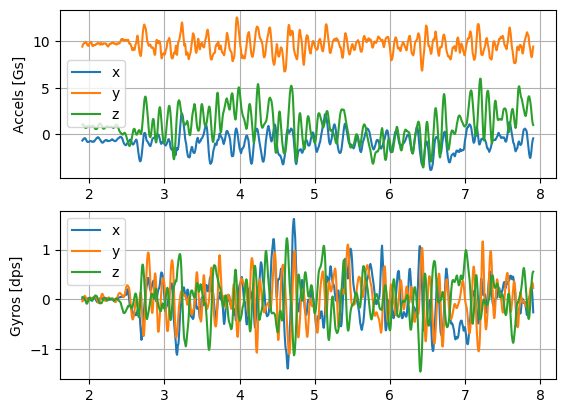

In [5]:
# imu_data = read_csv("camera/imu.csv")

imu_data = np.array(imu_data, dtype=np.float64)
dd = imu_data
t = dd[:,-1]
plt.subplot(2,1,1)
plt.plot(t,dd[:,0], label="x")
plt.plot(t,dd[:,1], label="y")
plt.plot(t,dd[:,2], label="z")
plt.grid(True)
plt.legend()
plt.ylabel("Accels [Gs]")
plt.subplot(2,1,2)
plt.plot(t,dd[:,3], label="x")
plt.plot(t,dd[:,4], label="y")
plt.plot(t,dd[:,5], label="z")
plt.grid(True)
plt.legend()
plt.ylabel("Gyros [dps]")

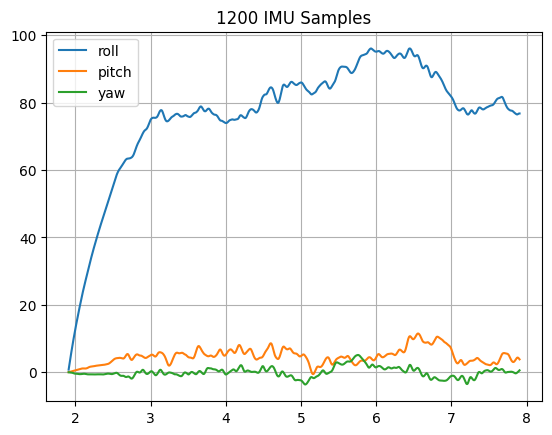

In [6]:
# alpha scales the accel values
cf = CF(0.01)

ts = []
qsave = []

last = imu_data[0][-1]
for v in imu_data:
    a = v[:3]
    g = v[3:6]
    t = v[-1]
    dt = t - last
    last = t
    q = cf.update(a,g,dt)
    qsave.append(q)
    ts.append(t)

rpy = np.array([Quaternion(*x).to_euler(degrees=True) for x in qsave])
plt.plot(ts,rpy[:,0],label="roll")
plt.plot(ts,rpy[:,1],label="pitch")
plt.plot(ts,rpy[:,2],label="yaw")
plt.grid(True)
plt.legend();
plt.title(f"{len(imu_data)} IMU Samples");

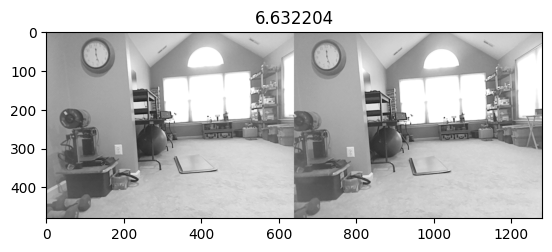

In [8]:
plt.imshow(imgs[15][0], cmap='gray')
plt.title(imgs[-1][1]);